In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using DataFrames
using MultivariateStats

In [2]:
using Flux
using Flux: logitcrossentropy, normalise, onecold, onehotbatch, crossentropy, throttle
using Statistics: mean
using Parameters: @with_kw
using Flux: @epochs

In [3]:
FPATH = "../../data/sampling_results/Benchmark-5/"

@load FPATH*"mcmc-summary-data.jld" data_save
data = data_save[1];

In [4]:
modeid = zeros(length(data.ev_index));

# mode = 1 : rotation ON, large charge
mask = data.ev_charge .> 15.0
mask = mask .* (data.ev_index .< 400)
modeid[mask] .= 1

# mode = 2 : rotation OFF, large charge
mask = data.ev_charge .> 15.0
mask = mask .* (data.ev_index .> 400)
modeid[mask] .= 2

# mode = 3 : rotation ON, small charge
mask = data.ev_charge .< 15.0
mask = mask .* (data.ev_index .< 519)
modeid[mask] .= 3

# mode = 4 : rotation OFF, small charge
mask = data.ev_charge .< 15.0
mask = mask .* (data.ev_index .>= 519)
modeid[mask] .= 4;

In [5]:
data = merge(data, (modeid=modeid,));

In [6]:
df = DataFrame(data);

# Define Dataset: 

In [7]:
imp_pars = [2,4,5,6,7,8,9,10,11,12,13, 18,21,22,23,24,25,26,27,28,29,30,37]
varnames = names(df)[imp_pars];

In [8]:
# Small Charge

mask = convert.(Bool, (data.modeid .== 3) .+ (data.modeid .== 4));

Y1 = df[mask,:].modeid .== 3 
X1 = collect(convert(Matrix,df[mask,imp_pars])');

In [9]:
# Large Charge

mask = convert.(Bool,(data.modeid .== 1) .+ (data.modeid .== 2));

Y2 = df[mask,:].modeid .== 1
X2 = collect(convert(Matrix,df[mask,imp_pars])');

In [10]:
@show size(X1), size(X2)

(size(X1), size(X2)) = ((23, 325), (23, 275))


((23, 325), (23, 275))

# Analysis: 

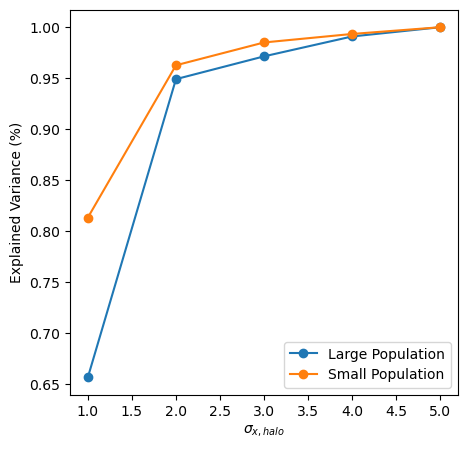

PyObject Text(24.000000000000007, 0.5, 'Explained Variance (%)')

In [29]:
M1 = fit(PCA, X1)
Xtr1 = MultivariateStats.transform(M1, X1)

M2 = fit(PCA, X2)
Xtr2 = MultivariateStats.transform(M2, X2);

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(eachindex(M1.prinvars), cumsum(M1.prinvars)./sum(M1.prinvars), "-o", label="Large Population")
ax.plot(eachindex(M2.prinvars), cumsum(M2.prinvars)./sum(M2.prinvars), "-o", label="Small Population")

ax.legend()
ax.set_xlabel("PCA Component")
# ax.set_xlabel(L"\sigma_{x, halo}")
ax.set_ylabel("Explained Variance (%)")

In [40]:
varnames_ed = 
    [L"q", L"\sigma_{x, halo}", L"\sigma_{y, halo}", L"\sigma_{x, core}", L"\sigma_{x, core}",
    L"\sigma'_{x, halo}", L"\sigma'_{y, halo}", L"\sigma'_{x, core}", L"\sigma'_{x, core}",
    L"s_{halo}", L"s_{core}", L"\beta", 
    L"<\sigma_{x, halo}>", L"<\sigma_{y, halo}>", L"<\sigma_{x, core}>", L"<\sigma_{x, core}>",
    L"<\sigma'_{x, halo}>", L"<\sigma'_{y, halo}>", L"<\sigma'_{x, core}>", L"<\sigma'_{x, core}>",
    L"<s_{halo}>", L"<s_{core}>", L"<\beta>",
];

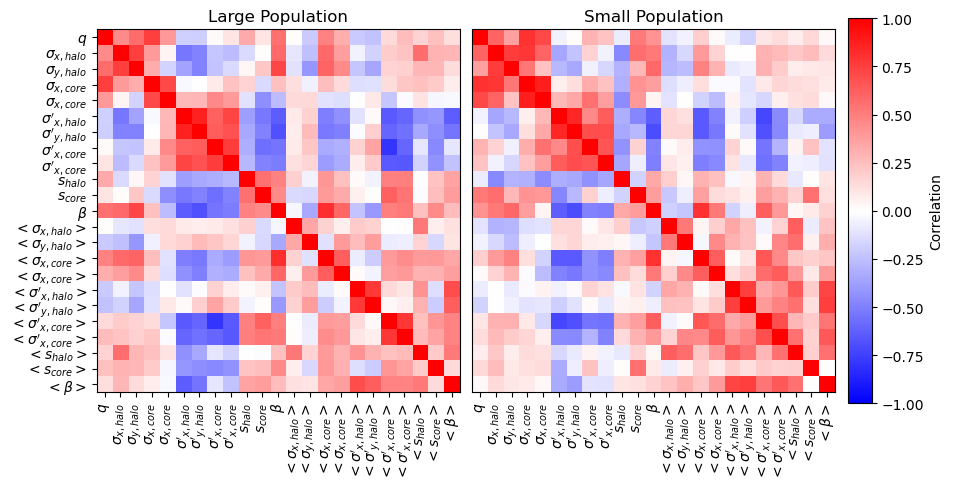

PyObject Text(0.5, 1.0, 'Small Population')

In [52]:
dttmp1 = (X1 .- mean(X1, dims = 2) )./ std(X1 .- mean(X1, dims = 2), dims=2)
dttmp2 = (X2 .- mean(X2, dims = 2) )./ std(X2 .- mean(X2, dims = 2), dims=2)

cv_tmp1 = cov(dttmp1, dims = 2)
cv_tmp2 = cov(dttmp2, dims = 2)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(10,5), gridspec_kw=Dict("width_ratios"=>[15,15, 1]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

maxval = maximum(abs.(cv_tmp1))

ax0.imshow(cv_tmp1,  origin="upper", cmap="bwr", vmin=-maxval, vmax=maxval, aspect="equal") 
cb = ax1.imshow(cv_tmp2,  origin="upper", cmap="bwr", vmin=-maxval, vmax=maxval, aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Correlation", cax=ax2)

ax0.set_yticks(0:size(X1, 1)-1)
ax0.set_yticklabels(varnames_ed)

ax0.set_xticks(0:size(X1, 1)-1)
ax0.set_xticklabels(varnames_ed, rotation = 90)

ax1.set_xticks(0:size(X1, 1)-1)
ax1.set_xticklabels(varnames_ed, rotation = 90)

ax1.set_yticks([]);
ax0.set_title("Large Population")
ax1.set_title("Small Population")


In [53]:
X1_tr = (X1 .- mean(X1, dims = 2) )./ std(X1 .- mean(X1, dims = 2), dims=2);
X2_tr = (X2 .- mean(X2, dims = 2) )./ std(X2 .- mean(X2, dims = 2), dims=2);

# M1 = fit(Whitening, X1)
# X1_tr = MultivariateStats.transform(M1, X1);
# M2 = fit(Whitening, X2)
# X2_tr = MultivariateStats.transform(M2, X2);

# ML: 

In [54]:
permuteind1 = shuffle(eachindex(Y1))
permuteind2 = shuffle(eachindex(Y2));

In [143]:
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y) 

function train(x, y; split_f = 0.75 )
    
    n_params, n_vectors = size(x)
    train_ind = zeros(Bool, n_vectors)
    train_ind[1:round(Int64, split_f*n_vectors)] .= one(Bool)
    shuffle!(train_ind)
    
    x_train, y_train = x[:, train_ind], y[:, train_ind]
    x_test, y_test = x[:, .!train_ind], y[:, .!train_ind]
    
    dat_load = Flux.Data.DataLoader(x_train, y_train) #batchsize=500, 
    
    model = Chain(
        Flux.Dense(n_params, 4, sigmoid), 
        Flux.Dense(4, 2), 
        softmax)
    
    accuracy_local(xd, yd) = accuracy(xd, yd, model)
    loss_local(xd, yd) = loss(xd, yd, model)
    
    loss_train_vec = Float64[]
    loss_test_vec = Float64[]
    accuracy_train_vec = Float64[]
    accuracy_test_vec = Float64[]
    
    evalcb = () -> begin 
        loss_train = loss_local(x_train, y_train)
        loss_test = loss_local(x_test, y_test)
        accur_train = accuracy_local(x_train, y_train)
        accur_test = accuracy_local(x_test, y_test)
        push!(loss_test_vec, loss_test)
        push!(loss_train_vec, loss_train)
        push!(accuracy_train_vec, accur_train)
        push!(accuracy_test_vec, accur_test)
        @info(loss_train, loss_test)
    end
    
    optimiser = ADAM()
    # Eng = 6 ep, Rus = 10
    @time @epochs 10 Flux.train!(loss_local, Flux.params(model), dat_load, optimiser, cb = throttle(evalcb, 20, leading=true,))
    
    return (
        model=model, 
        loss = (loss_train_vec, loss_test_vec), 
        acc = (accuracy_train_vec, accuracy_test_vec),
        trdata = (x_train, y_train), 
        tstdata=(x_test, y_test)
    )
end

function roc_curve(x, y, model; ind_neg = 1, ind_pos = 2, trange = range(0, stop=1, length=350))
    
    fp_rate = Float64[]
    tp_rate = Float64[]
    
    nneg = sum(y[ind_neg,:])
    npos = sum(y[ind_pos,:])
    
    prob = softmax(model(x), dims=1) 
    
    for i in trange
        
        pr_tmp = prob .> i
        pred_pos = pr_tmp[ind_pos,:]
        
        fpr = sum( y[ind_neg,:] .* pred_pos ) / nneg
        tpr = sum( y[ind_pos,:] .* pred_pos) / npos
        
        push!(fp_rate, fpr)
        push!(tp_rate, tpr)
        
    end
    
    s_ind = sortperm(fp_rate)
    x_int = diff(fp_rate[s_ind])
    y_int = tp_rate[s_ind]
    
    auc = sum(y_int[1:end-1] .* x_int + 0.5 .* x_int .* diff(y_int))
    
    return (fpr= fp_rate , tpr = tp_rate, auc = auc)
end

roc_curve (generic function with 1 method)

In [144]:
Y_tmp_1 = Y1[permuteind1]
Y_tmp_1 = onehotbatch(Y_tmp_1, 0:1)
X_tmp_1 = X1[:,permuteind1]

Y_tmp_2 = Y2[permuteind2]
Y_tmp_2 = onehotbatch(Y_tmp_2, 0:1)
X_tmp_2 = X2[:,permuteind2];

In [153]:
@load "../../data/sampling_results/Benchmark-5/classific_res.jld2" result1 result2

# result1 = train(X_tmp_1, Y_tmp_1)
# result2 = train(X_tmp_2, Y_tmp_2)
# @save "../../data/sampling_results/Benchmark-5/classific_res.jld2" result1 result2

model_tmp_1 = result1.model
trdata_1 = result1.trdata
tstdata_1 = result1.tstdata

model_tmp_2 = result2.model
trdata_2 = result2.trdata
tstdata_2 = result2.tstdata;

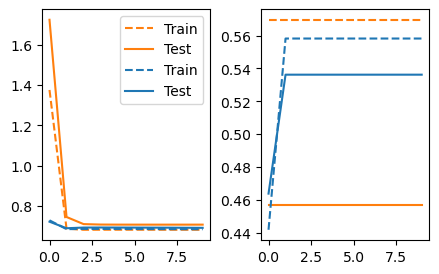

PyObject <matplotlib.legend.Legend object at 0x7f46fb4b4f10>

In [154]:
fig, ax = plt.subplots(1,2, figsize=(5,3))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

loss_vect1 = result1.loss
acc_vector1 = result1.acc

loss_vect2 = result2.loss
acc_vector2 = result2.acc

ax[1].plot(loss_vect1[1], color="C1", ls="--", label="Train")
ax[1].plot(loss_vect1[2], color="C1", ls="-", label="Test")

ax[1].plot(loss_vect2[1], color="C0", ls="--", label="Train")
ax[1].plot(loss_vect2[2], color="C0", ls="-", label="Test")

ax[2].plot(acc_vector1[1], color="C1", ls="--", label="Train")
ax[2].plot(acc_vector1[2], color="C1", ls="-", label="Test")

ax[2].plot(acc_vector2[1], color="C0", ls="--", label="Train")
ax[2].plot(acc_vector2[2], color="C0", ls="-", label="Test")

ax[1].legend()

In [155]:
roc_tr_1 = roc_curve(trdata_1..., model_tmp_1)
roc_test_1 = roc_curve(tstdata_1..., model_tmp_1);

roc_tr_2 = roc_curve(trdata_2..., model_tmp_2)
roc_test_2 = roc_curve(tstdata_2..., model_tmp_2);

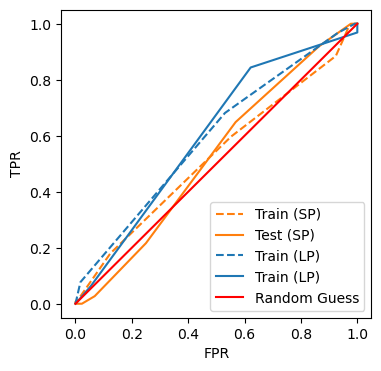

PyObject Text(24.0, 0.5, 'TPR')

In [156]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(roc_tr_1.fpr, roc_tr_1.tpr,  color="C1", ls="--", label="Train (SP)")
ax.plot(roc_test_1.fpr, roc_test_1.tpr, color="C1", ls="-", label="Test (SP)")

ax.plot(roc_tr_2.fpr, roc_tr_2.tpr,  color="C0", ls="--", label="Train (LP)")
ax.plot(roc_test_2.fpr, roc_test_2.tpr, color="C0", ls="-", label="Train (LP)")

ax.plot(0:1, 0:1, color="red", label="Random Guess")
ax.legend()

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

In [157]:
@show roc_tr_1.auc, roc_test_1.auc

(roc_tr_1.auc, roc_test_1.auc) = (0.5261390887290167, 0.5236486486486487)


(0.5261390887290167, 0.5236486486486487)

In [158]:
@show roc_tr_2.auc, roc_test_2.auc

(roc_tr_2.auc, roc_test_2.auc) = (0.5934065934065934, 0.6076858108108109)


(0.5934065934065934, 0.6076858108108109)